##### 第一模块(导入包模块：必须运行）

In [1]:
### 引入所有包,如果缺少某个包，包的名字附于之后
import numpy as np
# numpy

import pandas as pd
# pandas

import requests
# requests

from bs4 import BeautifulSoup
# BeautifulSoup

import re
# re

from fake_useragent import UserAgent
# fake-useragent

import json
# json

import time
# time

import random
# random

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
# selenium

from PIL import Image,ImageEnhance
# PIL

import hashlib
# hashlib

from collections import Counter
# collections

from gensim import corpora, models, similarities
# gensim 

import codecs, sys
# codecs

import os
# os

import time
#time

import shutil
# shutil

import jieba
# jieba

from pyhanlp import *
# pyhanlp，注意hanlp需要java的工具

import jpype
# jpype

import tensorflow as tf
# tensorflow

import matplotlib.pyplot as plt
# matplotlib

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import feature_extraction  
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer
# sklearn

from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams
from pdfminer.pdfparser import PDFParser, PDFDocument
from pdfminer.pdfdevice import PDFDevice
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
# pdfminer3k

from tkinter import *
from tkinter import filedialog
# tk文件导入模块

##### 第二模块(文件处理模块：必须运行）

In [2]:
def import_table(root):
    """
    return table:选中的表格
    """
    try:
        root.filename = filedialog.askopenfilename(filetypes=(("xlsx", "*.xlsx"),("xlsx", "*.xlsx")))        
        if ".xlsx" in root.filename:
            ### 该目录下有该文件
            table = pd.read_excel(root.filename)
            root.destroy()
            return table
    except Exception as e:
        root.destroy()
        print("导入错误")

def save_model(table):
    """
    Param table:需要导出的表
    """
    print("-------------------------------------------")
    print("以下为表格的预览:")
    print(table.head())
    flag = input("是否需要保存该摘要表？(输入Y/N):")
    try:
        if flag == "Y":
            save_file_name = input("请输入该词频表的名称(不用加.xlsx):")
            save_file_name_xlsx = save_file_name + ".xlsx" #导出excel文件
            table.to_excel(save_file_name_xlsx)
        else:
            pass
    except Exception as e:
        pass

##### 第三模块(核心分类器模块：必须运行）

In [3]:
## tf-idf建模后K-means聚类
def clean(single_para,stopwords_clean):
    """
    将stopwords和每一段文本取差集，清洗数据
    param single_para:没清洗文本集中的每一段数据
    return list_clean:每一段清洗好的文本
    """
    list_clean = set(single_para).difference(set(stopwords_clean))
    return list_clean

def data_prepare(text_list):
    """
    把数据清理干净
    param text_list:没清洗过的文本列表
    return list_clean:清洗过的文本列表
    """
    table_segments_list = list(map(lambda x:jieba.lcut(x),text_list))
    stopwords = list(map(lambda x:x.strip("\n"),codecs.open('stopwords.txt', 'r', 'utf-8').readlines()))
    stopwords_clean = list(map(lambda x:x.strip("\r"),stopwords))
    list_clean = list(map(clean,table_segments_list,stopwords_clean))
    return list_clean

def tf_idf_scikit(words):
    """
    使用scikit-learn建立tf-idf模型
    param words:清洗过的文本列表
    return tf-idf:tf-idf词袋模型
    """
    # 将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
    vectorizer = CountVectorizer()

    # 统计每个词语的tf-idf权值
    transformer = TfidfTransformer()

    # 第一个fit_transform是计算tf-idf 第二个fit_transform是将文本转为词频矩阵
    tfidf = transformer.fit_transform(vectorizer.fit_transform(words))

    # 获取词袋模型中的所有词语
    word = vectorizer.get_feature_names()

    # 将tf-idf矩阵抽取出来，元素w[i][j]表示j词在i类文本中的tf-idf权重
    weight = tfidf.toarray()
    return weight

def classifier(weight,clusters_num):
    """
    使用
    param weight:tf-idf的权重
    param clusters_num:分类簇心数量
    return list_classification:文本与分类结果列表
    """
    list_classification = []
    ## 设计随机种子
    random_status = random.randint(1,1000)

    ## 建立Kmeans分类器
    clf = KMeans(init='k-means++',n_clusters = clusters_num,random_state = random_status,n_init=10)

    ## PCA降维处理
    reduced_data = pca(weight)

    ## 训练
    s = clf.fit(reduced_data)
    
    ## 参数显示
    # print(np.shape(clf.cluster_centers_)) #簇心
    print("标签数量",clf.labels_) 
    print("簇心之间的平均欧氏距离",clf.inertia_) #簇心之间的欧氏距离

    ## 文章归类处理
    i = 1
    while i <= len(clf.labels_):
        list_classification.append(clf.labels_[i-1])
        i = i + 1
    return list_classification,clf

def pca(weights):
    reduced_data = PCA(n_components=2).fit_transform(weights)
    return reduced_data

def ploting(reduced_data,clf):
    h = .02
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

    # Plot the centroids as a white X
    centroids = clf.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

## 得到判决表
def data_input(table):
    """
    引入文本材料
    Param table:目标列表
    return table_judgements:含有目标文本的list
    """
    table_judgements = table.dropna()
    return table_judgements

def extract_something(pattern,elem):
    try:
        extract_infos = re.search(pattern_judgements,elem).group()
        return extract_infos
    except Exception as e:
        return "None"
    
def extract_PanJueRuXia(corpus):
    # 判决如下
    pattern_judgements = re.compile("判决如下:(.*?)。")
    corpus_judgements = list(map(extract_something,len(corpus) * [pattern_judgements],corpus))
    return corpus_judgements

#### 运行模块

----------------------------------------------
******************表格已经导入******************
----------------------------------------------
表格中所有的列: Index(['标题', '案号', '案件类型', '庭审程序', '案由', '文书类型', '法院', '判决日期', '原告', '被告',
       '第三人', '法官', '审判长', '审判员', '书记员', '头部', '头部2', '当事人', '当事人2', '庭审程序说明',
       '庭审程序说明2', '庭审过程', '庭审过程2', '庭审过程3', '庭审过程4', '庭审过程5', '庭审过程6', '法院意见',
       '法院意见2', '判决结果', '判决结果2', '庭后告知', '庭后告知2', '结尾', '结尾2', '附录', '附录2'],
      dtype='object')
请问需要分析哪一列的关键词词频？(输入关键词部分):判决结果


Building prefix dict from the default dictionary ...
I1101 14:51:27.991011 4749043136 __init__.py:111] Building prefix dict from the default dictionary ...


判决结果


Dumping model to file cache /var/folders/gj/d82ybwn16w54j4zq9x7z_ds80000gn/T/jieba.cache
I1101 14:51:28.555635 4749043136 __init__.py:145] Dumping model to file cache /var/folders/gj/d82ybwn16w54j4zq9x7z_ds80000gn/T/jieba.cache
Loading model cost 0.607 seconds.
I1101 14:51:28.599360 4749043136 __init__.py:163] Loading model cost 0.607 seconds.
Prefix dict has been built succesfully.
I1101 14:51:28.600308 4749043136 __init__.py:164] Prefix dict has been built succesfully.


请输入需要分类的主题数量:5
标签数量 [2 1 2 1 1 2 1 1 2 2 3 2 1 2 2 2 1 1 2 1 2 1 3 2 0 2 1 2 2 4 2 2 1 2 3 1 2
 2 4 4 2 1 2 2 2 1 1 1 2 2 1 2 4 1 3 2 1 3 3 2 1 2 1 2 4 4 3 2 2 1 1 1 4 2
 1 1 2 0 2 0 2 0 1 4 4 4 1 2 4 0 1 2 0 2 1 1 1 1 2 1 2 2 2 3 1 1 4 2 2 3 4
 1 1 1 2 2 1 1 4 2 1 2 2 1 1 3 1 1 4 4 3 1 2 1 0 3 3 1 2 1 3 1 1 2 0 2 1 2
 1 1 0 2 3 4 2 2 2 2 2 3 4 1 4 2 0 3 4 4 0 2 2 1 1 1 4 0 2 0 2 2 2 2 2 2 2
 3 2 0 3 2 2 1 1 1 1 1 1 1 2 0 1 2 1 4 1 4 3 3 4 2 4 4 0 2 4 4 0 4 4 3 3 4
 2 3 2 3 1 2 4 1 2 4 0 2 0 3 2 2 2 2 1 2 3 3 2 1 2 0 4 2 2 1 3 2 4 1 2 1 3
 1 3 2 2 2 2 3 1 0 1 3 4 3 1 2 2 2 2 1 1 2 2 2 2 1 1 1 2 1 2 0 1 1 2 0 1 4
 0 2 3 1 3 2 1 2 2 4 3 4 2 1 1 1 2 3 1 4 2 2 2 2 2 3 1 4 2 1 3 1 4 2 2 1 1
 1 1 2 2 2 1 2 3 3 4 3 3 1 3 2 3 2 3 4 2 2 3 4 4 1 2 2 2 2 2 4 0 1 3 0 1 2
 3 4 3 3 3 3 1 1 2 3 1 2 3 3 3 2 3 4 4 3 2 2 2 4 2 4 4 4 0 0 3 2 3 2 2 2 4
 1 3 3 4 2 2 3 3 1 3 1 2 3 4 4 4 2 3 3 2 2 3 3 4 4 4 0 2 2 2 4 3 4 3 3 1 1
 4 2 1 2 1 1 2 2 0 0 4 2 2 2 4 2 2 1 2 3 2 0 3 4 3 3 2 3 2 3 2 4 3 2 2 1 2
 2 2 

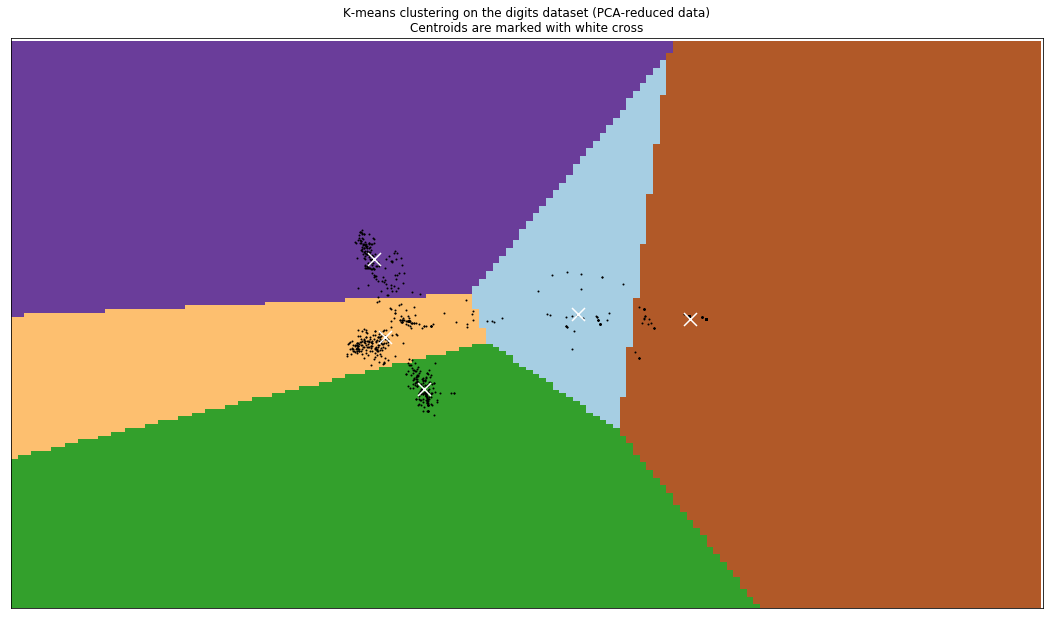

-------------------------------------------
以下为表格的预览:
                                                   0  1
0  依照《中华人民共和国民事诉讼法》第二百零四条第一款、《最高人民法院关于适用《中华人民共和国民...  2
1  依照《中华人民共和国民事诉讼法》第一百七十条第一款第（一）项的规定，判决如下:、驳回上诉，维...  1
2  综上，根据《中华人民共和国行政诉讼法》第五十四条第一项之规定，判决如下:、维持被告延津县公安...  2
3  依照《中华人民共和国民事诉讼法》第一百七十条第一款第（一）项规定，判决如下:、驳回上诉，维持...  1
4  依照《中华人民共和国民事诉讼法》第一百七十条第一款第（一）项之规定，判决如下:、驳回上诉，维...  1
是否需要保存该摘要表？(输入Y/N):N


In [4]:
if __name__ == '__main__':
    root = Tk() # 实例化TKinter窗口
    root.withdraw() # 隐藏TKinter窗口
    table_ready_to_eat = import_table(root)
    
    print("----------------------------------------------")
    print("******************表格已经导入******************")
    print("----------------------------------------------")
    print("表格中所有的列:",table_ready_to_eat.columns)
    selected_column = input("请问需要分析哪一列的关键词词频？(输入关键词部分):")
    print(selected_column)
    corpus = table_ready_to_eat[selected_column]
    
    table_judgements = data_input(pd.Series(corpus))
    data_test = data_prepare(table_judgements)

    ## 单词列表组成字符串
    words = list(map(lambda x:" ".join(list(x)),data_test))

    ## tf-idf转换weight
    weight = tf_idf_scikit(words)

    ## 请输入主题分类数量
    num_topics = int(input("请输入需要分类的主题数量:"))
    
    ## 分类器得到分类
    list_classification,clf = classifier(weight,num_topics)

    ## pca降维
    reduced_data = pca(weight)

    ## 将分类情况可视化
    ploting(reduced_data,clf)

    ## 将分类结果形成列表
    table_kmeans_result = pd.DataFrame([list(table_judgements),list_classification]).T
    
    ## 存储该表
    save_model(table_kmeans_result)